In [1]:
import numpy as np
import os, random
from PIL import Image
import json
import glob

In [2]:
# imagenet_mean = [0.485, 0.456, 0.406]
# imagenet_std = [0.229, 0.224, 0.225]
imagenet_mean = 0.448
imagenet_std = 0.226

## attn 256 256
# wp_mean = 8.708306e-07
# wp_std = 0.023440132

## mlp 32 32
# wp_mean = -5.42295056421355e-06
# wp_std =  0.011819059083636133

def make_image_format(tensor, wp_mean, wp_std, c):
    tensor = (tensor - wp_mean) / wp_std
    tensor = tensor * imagenet_std * c + imagenet_mean
    tensor = np.clip(tensor, 0, 1)
    tensor = tensor * 255  # Grayscale image data (100x100 pixels)
    tensor = tensor.astype(np.uint8)
    return tensor

def reverse_image_format(tensor, wp_mean, wp_std, c):
    # uint8에서 float로 변환하고 255로 나누어 0-1 범위로 정규화
    tensor = tensor.astype(np.float32) / 255.0
    
    # 클리핑을 무시하므로 클리핑 이전의 값으로 가정
    tensor = tensor - imagenet_mean  # imagenet_mean을 빼기
    tensor = tensor / (imagenet_std * c)  # (imagenet_std * c)로 나누기
    tensor = tensor * wp_std + wp_mean  # wp_std로 곱하고 wp_mean을 더하기
    return tensor

def calculate_mse(array1, array2):
    # 두 배열의 차이를 계산
    difference = array1 - array2
    # 차이의 제곱을 계산
    squared_difference = np.square(difference)
    # 제곱된 차이의 평균을 계산
    mse = np.mean(squared_difference)
    return mse

from PIL import Image
import numpy as np

def png_to_numpy_array(file_path):
    # PNG 파일 읽기
    image = Image.open(file_path)
    # 이미지를 NumPy 배열로 변환
    image_array = np.array(image)
    return image_array

# # 사용 예시
# png_file_path = 'path/to/your/image.png'  # 여기에서 PNG 파일의 경로를 지정하세요.
# image_array = png_to_numpy_array(png_file_path)

# # 결과 출력
# print("NumPy Array:")
# print(image_array)
# print("Shape:", image_array.shape)

## 32 32 이미지 만들기

In [3]:
dir_path = '/home/jgryu/Weight_compression/Wparam_dataset/tmp/train/attn_tensor_path_train/'
save_path = '/home/jgryu/Weight_compression/JPEG/wp_image/size32_32'
save_npy_path = '/home/jgryu/Weight_compression/JPEG/wp_npy/size32_32'

In [4]:
# path_json = '/home/jgryu/Weight_compression/Wparam_dataset/path_json/meta-llama-3-8b_mlp_train.json'
# with open(path_json, 'r') as file:
#     tenosr_list = json.load(file)
# print(len(tenosr_list))

npy = '/home/jgryu/Weight_compression/Wparam_dataset/npy/meta-llama-3-8b_mlp_size-128-1024_val.npy'
data = np.load(npy)
print(data.shape)

(8960, 128, 1024)


In [5]:
data = data.reshape(-1, 1024)

In [6]:
np.random.seed(100)
indices = np.random.choice(data.shape[0], 1000, replace=False)
sampled_data = data[indices]
print(sampled_data.shape)

os.makedirs(save_npy_path, exist_ok = True)
for i in range(sampled_data.shape[0]):
    n = sampled_data[i]
    np.save(save_npy_path + f'/{i}.npy', n)

(1000, 1024)


In [7]:
for c in [0.5, 0.7, 1, 1.2, 1.5, 2]:
    for i in range(sampled_data.shape[0]):
        n = sampled_data[i]
        n = make_image_format(n, c)
        # print(n.shape, n.max(), n.min(), n.mean()), n.std()
        
        img = Image.fromarray(n, mode='L')  # 'L' mode is for grayscale
        directory = f"{save_path}/c={c}"
        if not os.path.exists(directory):
            os.mkdir(directory)
        img.save(f"{save_path}/c={c}/{i}.png")

TypeError: make_image_format() missing 2 required positional arguments: 'wp_std' and 'c'

## 256 256 이미지 만들기 mlp

In [ ]:
# dir_path = '/home/jgryu/Weight_compression/Wparam_dataset/tmp/train/attn_tensor_path_train/'
save_path = '/home/jgryu/Weight_compression/JPEG/wp_image/mlp_size256_256'
save_npy_path = '/home/jgryu/Weight_compression/JPEG/wp_npy/mlp_size256_256'

In [ ]:
dataset_folder = "/home/jgryu/Weight_compression/Wparam_dataset/image_shape_wp/meta-llama-3-8b_mlp_val_json/256_256"
directories = [os.path.join(dataset_folder, d) for d in os.listdir(dataset_folder) if os.path.isdir(os.path.join(dataset_folder, d))]
print(directories)
wp_path_list = glob.glob(f'{directories[0]}/**/*.npy', recursive=True)
print(len(wp_path_list))

random.seed(100)
random_list = random.sample(wp_path_list, 1000)
wp_path_list = random_list

mean = np.load(dataset_folder + f'/mean_value.npy')
std = np.load(dataset_folder + f'/std_value.npy')


['/home/jgryu/Weight_compression/Wparam_dataset/image_shape_wp/meta-llama-3-8b_mlp_val_json/256_256/Meta-Llama-3-8B']
17920


In [ ]:
os.makedirs(save_npy_path, exist_ok = True)
for i in range(len(wp_path_list)):
    n = np.load(wp_path_list[i])
    np.save(save_npy_path + f'/{i}.npy', n)

for c in [0.5, 0.7, 1, 1.2, 1.5, 2]:
    for i in range(len(wp_path_list)):
        n = np.load(wp_path_list[i])
        n = make_image_format(n,wp_mean=mean, wp_std=std, c=c)
        # print(n.shape, n.max(), n.min(), n.mean()), n.std()
        
        img = Image.fromarray(n, mode='L')  # 'L' mode is for grayscale
        directory = f"{save_path}/c={c}"
        # if not os.path.exists(directory):
        #     os.mkdir(directory)
        os.makedirs(directory, exist_ok=True)
        img.save(f"{save_path}/c={c}/{i}.png")

## 256 256 이미지 만들기 attn

In [ ]:
files = os.listdir(dir_path)
random.seed(100)
files = random.sample(files, 100)
print(sorted(files))

['100718.npy', '103301.npy', '103912.npy', '109315.npy', '116354.npy', '118339.npy', '119369.npy', '120562.npy', '122489.npy', '122498.npy', '123844.npy', '129262.npy', '132974.npy', '133904.npy', '138193.npy', '140840.npy', '14952.npy', '156843.npy', '157270.npy', '166694.npy', '166831.npy', '178502.npy', '179097.npy', '185153.npy', '188326.npy', '193856.npy', '194607.npy', '19737.npy', '200556.npy', '204050.npy', '208201.npy', '208216.npy', '209574.npy', '209939.npy', '210884.npy', '214382.npy', '21492.npy', '215936.npy', '217206.npy', '219963.npy', '220092.npy', '224214.npy', '22858.npy', '238344.npy', '239862.npy', '240141.npy', '240610.npy', '242128.npy', '247414.npy', '252717.npy', '259156.npy', '259559.npy', '269671.npy', '275028.npy', '275405.npy', '284220.npy', '285166.npy', '289135.npy', '294876.npy', '300216.npy', '302389.npy', '302553.npy', '310456.npy', '311723.npy', '321292.npy', '32236.npy', '328017.npy', '3292.npy', '335772.npy', '343476.npy', '344335.npy', '345097.npy'

In [ ]:
for c in [0.5, 0.7, 1, 1.2, 1.5, 2]:
    for i in files:
        path = dir_path + i
        n = np.load(path)
        # print(n.shape, n.max(), n.min(), n.mean(), n.std())
        n = make_image_format(n, c)
        # print(n.shape, n.max(), n.min(), n.mean()), n.std()
        
        img = Image.fromarray(n, mode='L')  # 'L' mode is for grayscale
        directory = f"{save_path}c={c}"
        if not os.path.exists(directory):
            os.mkdir(directory)
        img.save(f"{save_path}c={c}/{i}".replace('.npy', '.png'))

In [ ]:
# Convert to a Pillow image and save
img = Image.fromarray(data, mode='L')  # 'L' mode is for grayscale
img.save("output_image_grayscale.png")

## log 파일 읽고 그래프 그리기

In [ ]:
def read_avg_after_avg_line(file_path):
    avg_value = None

    # 파일 열기
    with open(file_path, 'r') as file:
        # 파일의 모든 줄을 읽기
        lines = file.readlines()
        # 마지막 줄부터 역순으로 확인
        for i in range(len(lines) - 1):  # -1로 마지막 줄을 제외
            line = lines[i].strip()  # 공백 제거
            if line.startswith("AVG"):
                # 다음 줄의 숫자 읽기
                next_line = lines[i + 1].strip()  # 다음 줄
                avg_value = next_line  # 다음 줄의 값

    return float(avg_value) if avg_value is not None else None

# # 사용 예시
# log_file_path = '/home/jgryu/Weight_compression/JPEG/log_JPEG_wp_c=0.5_bpp_0.1.txt'
# last_avg_result = read_avg_after_avg_line(log_file_path)

# if last_avg_result is not None:
#     print(f"AVG 다음 줄의 값: {last_avg_result}")
# else:
#     print("AVG 값을 찾을 수 없습니다.")


In [ ]:
# data = {}
# for c in [0.5, 0.7, 1, 1.2, 1.5, 2]:
#     mses = []
#     bpps = []
#     for bpp in [0.1, 0.5, 0.6]:
#         # source_path = f'/home/jgryu/Weight_compression/JPEG/wp_image/c={c}/'
#         # result_path = f'/home/jgryu/Weight_compression/JPEG/wp_image_result/c={c}/bpp{bpp}/'
#         source_path = f'/home/jgryu/Weight_compression/JPEG/wp_image/size32_32/c={c}/'
#         result_path = f'/home/jgryu/Weight_compression/JPEG/wp_image_result/size32_32/c={c}/bpp{bpp}/'

#         mse_list = []
#         for i in files:
#             i = i.replace('.npy', '.png')
#             path = source_path + i
#             before = png_to_numpy_array(path)
#             before = reverse_image_format(before, c)
            
#             i = i.replace('.png', '.jpg')
#             path = result_path + i
#             after = png_to_numpy_array(path)
#             after = reverse_image_format(after, c)
            
#             mse_list.append(calculate_mse(before, after))
            
#         average = np.mean(mse_list)
#         print("MSE:", average)
        
#         mses.append(average)
        
#         log_file_path = f'/home/jgryu/Weight_compression/JPEG/log_JPEG_wp_c={c}_bpp_{bpp}.txt'
#         last_avg_result = read_avg_after_avg_line(log_file_path)
#         print(f"Bpp: {last_avg_result}")
        
#         bpps.append(last_avg_result)
        
    

MSE: 0.00020132348
MSE_from_npy: 0.00020169961
Bpp: 0.1198311767578125
MSE: 0.00020132348
MSE_from_npy: 0.00020169961
Bpp: 0.1198311767578125
MSE: 0.00016076388
MSE_from_npy: 0.0001619002
Bpp: 0.2291676025390625
MSE: 0.00015228374
MSE_from_npy: 0.00015332451
Bpp: 0.3298985595703125
MSE: 0.00014511003
MSE_from_npy: 0.00014613794
Bpp: 0.426707763671875
MSE: 0.00013838748
MSE_from_npy: 0.00013939869
Bpp: 0.5226209716796875
MSE: 0.00013244938
MSE_from_npy: 0.00013342685
Bpp: 0.622935791015625
MSE: 0.00012667019
MSE_from_npy: 0.0001276223
Bpp: 0.7228359375
MSE: 0.000120654586
MSE_from_npy: 0.00012156938
Bpp: 0.8212601318359375
MSE: 0.00017459391
MSE_from_npy: 0.00017812275
Bpp: 0.187216064453125
MSE: 0.00017459391
MSE_from_npy: 0.00017812275
Bpp: 0.187216064453125
MSE: 0.00016471135
MSE_from_npy: 0.00016846585
Bpp: 0.2357015380859375
MSE: 0.00015207037
MSE_from_npy: 0.00015569094
Bpp: 0.337572021484375
MSE: 0.00014328405
MSE_from_npy: 0.00014669629
Bpp: 0.4325718994140625
MSE: 0.0001361033


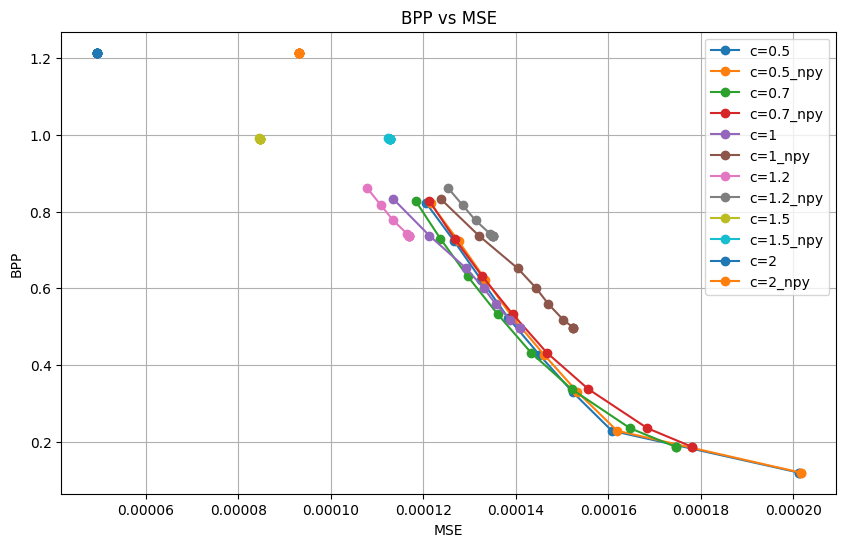

In [9]:
import matplotlib.pyplot as plt
# 메인 데이터 수집 코드

data = {}
# source_npy_path = f'/home/jgryu/Weight_compression/JPEG/wp_npy/size32_32/'
source_npy_path = f'/home/jgryu/Weight_compression/JPEG/wp_npy/mlp_size256_256/'
for c in [0.5, 0.7, 1, 1.2, 1.5, 2]:
    mses = []
    mses_npy = []
    bpps = []
    for bpp in [0.1, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]:
        # source_path = f'/home/jgryu/Weight_compression/JPEG/wp_image/size32_32/c={c}/'
        # result_path = f'/home/jgryu/Weight_compression/JPEG/wp_image_result/size32_32/c={c}/bpp{bpp}/'
        source_path = f'/home/jgryu/Weight_compression/JPEG/wp_image/mlp_size256_256/c={c}/'
        result_path = f'/home/jgryu/Weight_compression/JPEG/wp_image_result/mlp_size256_256/c={c}/bpp{bpp}/'

        mse_list = []
        mse_from_npy = []
        files = os.listdir(source_path)
        for i in files:  # files는 미리 정의된 리스트라고 가정
            path = source_path + i
            before = png_to_numpy_array(path)
            before = reverse_image_format(before, wp_mean=mean,wp_std=std, c=c)
            before_npy = np.load(source_npy_path + i.replace('.png', '.npy'))
            
            i = i.replace('.png', '.jpg')
            path = result_path + i
            after = png_to_numpy_array(path)
            after = reverse_image_format(after, wp_mean=mean,wp_std=std, c=c)

            mse_list.append(calculate_mse(before, after))
            mse_from_npy.append(calculate_mse(before_npy, after))

        average_mse = np.mean(mse_list)
        average_mse_npy = np.mean(mse_from_npy)
        print("MSE:", average_mse)
        print("MSE_from_npy:", average_mse_npy)

        mses.append(average_mse)
        mses_npy.append(average_mse_npy)
        # log_file_path = f'/home/jgryu/Weight_compression/JPEG/logs/size32_32/log_JPEG_wp_c={c}_bpp_{bpp}.txt'
        log_file_path = f'/home/jgryu/Weight_compression/JPEG/logs/mlp_size256_256/log_JPEG_wp_32_32_c={c}_bpp_{bpp}.txt'
        last_avg_result = read_avg_after_avg_line(log_file_path)
        print(f"Bpp: {last_avg_result}")

        bpps.append(last_avg_result)

    # 데이터 저장
    data[c] = {'mses': mses, 'mse_from_npy': mses_npy, 'bpps': bpps}

# MSE 대 BPP 그래프 그리기
plt.figure(figsize=(10, 6))
for c, values in data.items():
    plt.plot(values['mses'], values['bpps'], marker='o', label=f'c={c}')
    plt.plot(values['mse_from_npy'], values['bpps'], marker='o', label=f'c={c}_npy')

plt.title('BPP vs MSE')
plt.xlabel('MSE')
plt.ylabel('BPP')
# plt.xticks(np.arange(0, max(mses) + 0.01, 0.01))  # MSE의 범위를 조정
plt.grid()
plt.legend()
plt.show()

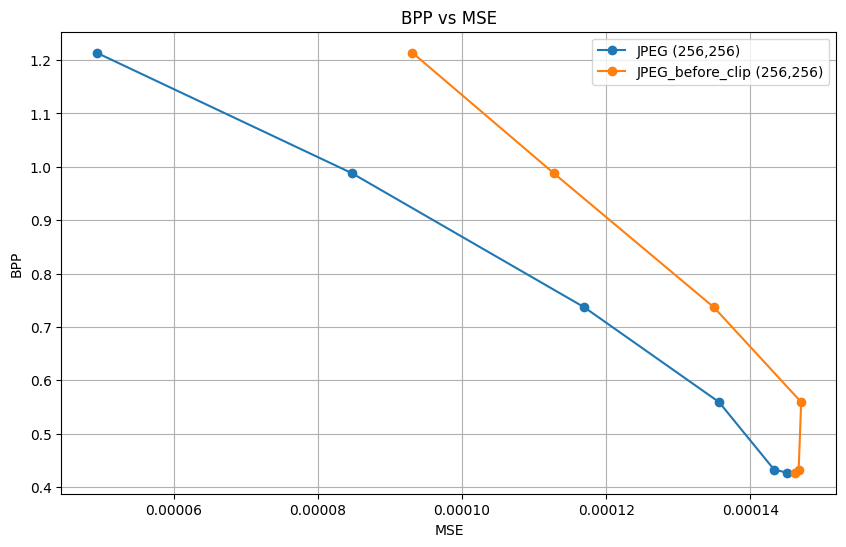

In [12]:
mse_list = []
mse_npy_list = []
bpp_list = []
for c, values in data.items():
    mse_list.append(values['mses'][4])
    mse_npy_list.append(values['mse_from_npy'][4])
    bpp_list.append(values['bpps'][4])
    
    # plt.plot(values['mses'], values['bpps'], marker='o', label=f'c={c}')


plt.figure(figsize=(10, 6))
plt.plot(mse_list, bpp_list, marker='o', label=f'JPEG (256,256)')
plt.plot(mse_npy_list, bpp_list, marker='o', label=f'JPEG_before_clip (256,256)')

plt.title('BPP vs MSE')
plt.xlabel('MSE')
plt.ylabel('BPP')
# plt.xticks(np.arange(0, max(mses) + 0.01, 0.01))  # MSE의 범위를 조정
plt.grid()
plt.legend()
plt.show()

In [11]:
for i in range(len(mse_list)):
    print(mse_npy_list[i], bpp_list[i])

0.00014613794 0.426707763671875
0.00014669629 0.4325718994140625
0.00014704333 0.559120361328125
0.00013494283 0.736552490234375
0.000112696354 0.9881512451171875
9.3104405e-05 1.2137393798828124


In [13]:
for i in range(len(mse_list)):
    print(mse_list[i], bpp_list[i])

0.00014511003 0.426707763671875
0.00014328405 0.4325718994140625
0.00013564229 0.559120361328125
0.00011696918 0.736552490234375
8.468635e-05 0.9881512451171875
4.9290877e-05 1.2137393798828124
